# UNeXt 
> https://github.com/jeya-maria-jose/UNeXt-pytorch

In [1]:
%config Completer.use_jedi = False

## 引入依赖包

In [2]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.3 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4937e3cf3b1d4b8447904a440ec27da2035079e9f03ae28e25f294e9bc45d948
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0421ccbbcb66fdf0eb6009bc57757ea218545373c0e388df77413ae4d745e2fb
  Stored in directory: /root/.cache/pip/wheels/ed/27/

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## 设置wandb账号
用作统计与数据分析

In [4]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


In [5]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
# from utils import *

import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
import pdb



def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)


def shift(dim):
            x_shift = [ torch.roll(x_c, shift, dim) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
            x_cat = torch.cat(x_shift, 1)
            x_cat = torch.narrow(x_cat, 2, self.pad, H)
            x_cat = torch.narrow(x_cat, 3, self.pad, W)
            return x_cat

class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    
#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x) 
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class UNext(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[ 128, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.input_channels = input_channels
        self.encoder1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(32, 128, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(160)
        self.dnorm4 = norm_layer(128)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(256, 160, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(160, 128, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(128, 32, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(160)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)
        
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


class UNext_S(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP w less parameters
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[32, 64, 128, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(8)
        self.ebn2 = nn.BatchNorm2d(16)
        self.ebn3 = nn.BatchNorm2d(32)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(64)
        self.dnorm4 = norm_layer(32)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(128, 64, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(32, 16, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(8, 8, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(64)
        self.dbn2 = nn.BatchNorm2d(32)
        self.dbn3 = nn.BatchNorm2d(16)
        self.dbn4 = nn.BatchNorm2d(8)
        
        self.final = nn.Conv2d(8, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


#EOF


## DataSet

In [6]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size, channels = 3) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        transformers = [
            transforms.Resize(size),
            transforms.ToTensor()
        ]
        if channels == 1:
            transformers.insert(0, transforms.Grayscale(num_output_channels=1))

        # 设置 transforms
        self.transform = transforms.Compose(transformers)
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


In [7]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


### 检查异常图片
要把找到的异常数据去除

In [8]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 80: 


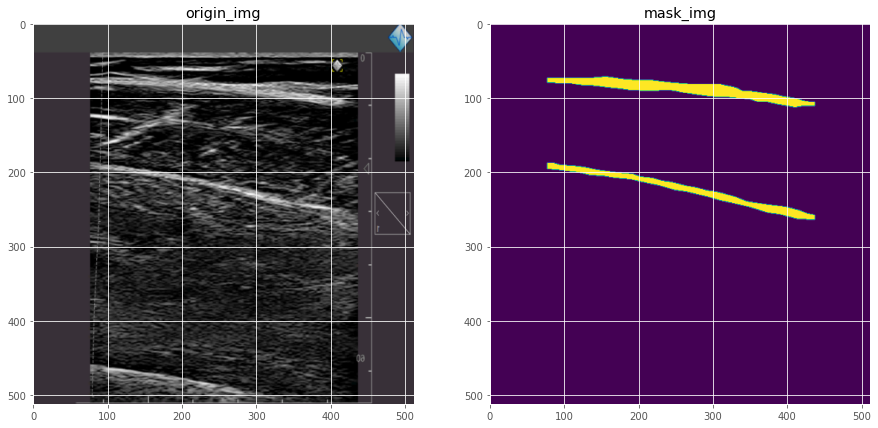

In [9]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

## 模型训练

In [10]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        num_classes = net.module.num_classes
    else:
        num_classes = net.num_classes
    criterion = nn.CrossEntropyLoss() if num_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          project = 'U-Net',
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    
    if isinstance(model, nn.DataParallel):
        num_classes = model.module.num_classes
        input_channels = model.module.input_channels
    else:
        num_classes = model.num_classes
        input_channels = model.input_channels
        
    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
#                               nesterov=config['nesterov'], weight_decay=config['weight_decay'])

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    criterion = nn.CrossEntropyLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()
    
    global_step = 0
    

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == input_channels, \
                    f'Network has been defined with {input_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            


In [12]:
model = UNext(input_channels=3, num_classes=1, img_size=512)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(memory_format=torch.channels_last)
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"U-Next模型参数量为：{total_params}")
print("其详情为：")
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())
    
train(model, device, project='U-Next')


U-Next模型参数量为：1471921
其详情为：
encoder1.weight : torch.Size([16, 3, 3, 3])
encoder1.bias : torch.Size([16])
encoder2.weight : torch.Size([32, 16, 3, 3])
encoder2.bias : torch.Size([32])
encoder3.weight : torch.Size([128, 32, 3, 3])
encoder3.bias : torch.Size([128])
ebn1.weight : torch.Size([16])
ebn1.bias : torch.Size([16])
ebn2.weight : torch.Size([32])
ebn2.bias : torch.Size([32])
ebn3.weight : torch.Size([128])
ebn3.bias : torch.Size([128])
norm3.weight : torch.Size([160])
norm3.bias : torch.Size([160])
norm4.weight : torch.Size([256])
norm4.bias : torch.Size([256])
dnorm3.weight : torch.Size([160])
dnorm3.bias : torch.Size([160])
dnorm4.weight : torch.Size([128])
dnorm4.bias : torch.Size([128])
block1.0.norm2.weight : torch.Size([160])
block1.0.norm2.bias : torch.Size([160])
block1.0.mlp.fc1.weight : torch.Size([160, 160])
block1.0.mlp.fc1.bias : torch.Size([160])
block1.0.mlp.dwconv.dwconv.weight : torch.Size([160, 1, 3, 3])
block1.0.mlp.dwconv.dwconv.bias : torch.Size([160])
block1.0